In [1]:
from keras.models import load_model
import mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from os import listdir
import zipfile
import os
from numpy import savez_compressed
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
#Download facenet model used for face recognition (Takes a picture and able to see who it belongs to)

!wget --no-check-certificate \
    https://dl.dropboxusercontent.com/s/3d6dx53bjn5kiyv/facenet_keras.h5?dl=0 \
    -O /content/facenet.h5

--2020-07-06 09:50:48--  https://dl.dropboxusercontent.com/s/3d6dx53bjn5kiyv/facenet_keras.h5?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92397640 (88M) [application/octet-stream]
Saving to: ‘/content/facenet.h5’

/content/facenet.h5 100%[===================>]  88.12M  49.1MB/s    in 1.8s    

2020-07-06 09:50:51 (49.1 MB/s) - ‘/content/facenet.h5’ saved [92397640/92397640]



In [3]:
model = load_model('facenet.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
#Library for face detection (Create bounding box over the face)

!pip install mtcnn

In [5]:
def extract_face(filename,required_size=(160,160)):
  #Load image from file
  img = Image.open(filename)
  #Convert to RGB if needed (Since the facenet requires images to be colored)
  img = img.convert('RGB')
  #Convert image to numpy array
  pixels = asarray(img)

  #Create the face detector
  detector = MTCNN()
  #Detect the face using the numpy array obtained
  results = detector.detect_faces(pixels)

  #Extract bounding box of the first face
  x1,y1,width,height = results[0]['box']
  #Bug fix
  x1 , y1 = abs(x1), abs(y1)
  #Get x2 and y2 using the width and height
  x2 = x1 + width
  y2 = y1 + height

  #Extract the face from the image
  face = pixels[y1:y2, x1:x2]
  #Get the image from the extracted pixels
  img = Image.fromarray(face)
  #Resize image to required size (For the facenet model)
  img = img.resize(required_size)
  #Get back the array of the resized face image
  face_pixels = asarray(img)
  return face_pixels

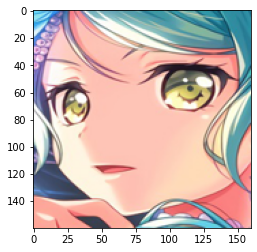

In [6]:
face_px = extract_face('face.jpg')
plt.imshow(face_px)

In [7]:
def unzip(filename,dir):
  with zipfile.ZipFile(filename, 'r') as zip_ref:
      zip_ref.extractall(dir)

In [8]:
!wget --no-check-certificate \
  https://dl.dropboxusercontent.com/s/bb3nq9urxvytl6w/5_celebs_dataset.zip?dl=0 \
  -O /content/5celeb

--2020-07-06 09:51:05--  https://dl.dropboxusercontent.com/s/bb3nq9urxvytl6w/5_celebs_dataset.zip?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5275912 (5.0M) [application/zip]
Saving to: ‘/content/5celeb’

/content/5celeb     100%[===================>]   5.03M  25.1MB/s    in 0.2s    

2020-07-06 09:51:06 (25.1 MB/s) - ‘/content/5celeb’ saved [5275912/5275912]



In [9]:
unzip(filename='5celeb',dir='/content/5_celeb_dataset')

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


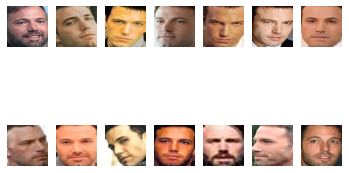

In [10]:
#Test out on ben afflek (training)

folder = '/content/5_celeb_dataset/train/ben_afflek/'

i = 1

#Enumerate through the directory, extracting the face from every picture in the dir
#listdir(folder) will give all the names of the .jpg files in the folder. Hence, file will be the name of a jpg file
for filename in listdir(folder):
  #Get the full path of the .jpg file
  path = os.path.join(folder, filename)
  #Get the extracted face pixel
  face = extract_face(path)
  print(i, face.shape)
  
  #Plot the images
  #Create a subplot of 2 rows, 7 columns and specify that you will plot the image at the ith index (You havent done it yet)
  plt.subplot(2,7,i)
  plt.axis('off')
  #Plot the image at the ith index and show it
  plt.imshow(face)
  #Increase by i, so that for the next image it will be plotted on the next area in the subplot 
  i += 1

In [11]:
#Function for creating a list of all the face image arrays, from a given folder

def load_faces(folder):
  faces = []
  for filename in listdir(folder):
    path = os.path.join(folder, filename)
    face = extract_face(path)
    faces.append(face)
  return faces

In [12]:
def load_dataset(directory):
  #List of numpy arrays of faces
  x = []
  #List of labels
  y = []

  for subdir in listdir(directory):
    path = directory + subdir + '/'
    print(path)
    #Skip any files that are in the directory (Only perform subsequent operations on sub directories)
    #If it is not a directory, skip this whole iteration and go on to the next loop
    if not os.path.isdir(path):
      continue
    #create a list containing all the image arrays in the sub directory
    '''This will be [
      [eg1],
      [eg2],
      [eg3]
    ]
    '''
    faces = load_faces(path)
    #Create the labels. This creates a list of labels for all the images in 1 sub directory (etc: train/ben_afflek)
    #the labels will be the name of the celebrity (which is the subdir name). labels will be a list that repeats the name len(faces) times (If there are 5 egs of ben affleck, there will be 5 'ben affleck' inside the list)
    labels = [subdir for _ in range(len(faces))]
    print(f'Loaded {len(faces)} examples for class {subdir}')

    '''
    Use extend instead of append for x. Because faces is a list containing a list of arrays. So, by using extend you will do this:
    x = [
      [eg1],
      [eg2],
      [eg3],
      ....,
      [eg45]
    ]


    If you used append instead you will end up appending the whole list object to the list instead of an element wise appending to the list
    x = [
      [eg1],
      [eg2],
      ...,
      [
        [eg44],[eg45]
        ]
    ]
    '''
    x.extend(faces)
    #use extend, so you are able to add a list to another list ELEMENT-WISE. e.g [1,2,3,5,7]
    #If you use append instead you will append the whole list object instead of looping through it and appending element-wise. So, you get [1,2,[3,5,7]] instead!
    y.extend(labels)

  return asarray(x), asarray(y)

In [13]:
x_train , y_train = load_dataset('5_celeb_dataset/train/')
print(x_train.shape,y_train.shape)
x_test, y_test = load_dataset('5_celeb_dataset/val/')
print(x_test.shape, y_test.shape)
savez_compressed('/content/5_celeb_faces_dataset.npz', x_train, y_train, x_test, y_test)

5_celeb_dataset/train/ben_afflek/
Loaded 14 examples for class ben_afflek
5_celeb_dataset/train/elton_john/
Loaded 17 examples for class elton_john
5_celeb_dataset/train/madonna/
Loaded 19 examples for class madonna
5_celeb_dataset/train/jerry_seinfeld/
Loaded 21 examples for class jerry_seinfeld
5_celeb_dataset/train/mindy_kaling/
Loaded 22 examples for class mindy_kaling
(93, 160, 160, 3) (93,)
5_celeb_dataset/val/ben_afflek/
Loaded 5 examples for class ben_afflek
5_celeb_dataset/val/elton_john/
Loaded 5 examples for class elton_john
5_celeb_dataset/val/madonna/
Loaded 5 examples for class madonna
5_celeb_dataset/val/jerry_seinfeld/
Loaded 5 examples for class jerry_seinfeld
5_celeb_dataset/val/mindy_kaling/
Loaded 5 examples for class mindy_kaling
(25, 160, 160, 3) (25,)


In [14]:
#load the .npz file
data = np.load('5_celeb_faces_dataset.npz')
#Split to training and testing, x and y
x_train, y_train, x_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(93, 160, 160, 3)
(93,)
(25, 160, 160, 3)
(25,)


In [15]:
#Load facenet model
model = load_model('facenet.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
#Get the embeddings for one face

def get_embedding(model, face_pixel):
  #Convert to float32
  face_pixel = face_pixel.astype('float32')
  #Standardize pixel values
  mean, std = face_pixel.mean(), face_pixel.std()
  face_pixel = (face_pixel- mean) / std
  #In order to predict for one example, must add one dimension to the array
  sample = np.expand_dims(face_pixel, axis=0)
  #Make prediction to get embeddings
  pred = model.predict(sample)
  return pred[0]

In [17]:
print(x_train[1].shape)

(160, 160, 3)


In [18]:
#The embeddings for training and testing
e_x_train = []
e_x_test = []

#Loop through all faces and get their embeddings, appending it to a list
#face is an array of a single face image
for face in x_train:
  embedding = get_embedding(model,face_pixel=face)
  e_x_train.append(embedding)
for face in x_test:
  embedding = get_embedding(model,face_pixel=face)
  e_x_test.append(embedding)

#Convert list to a numpy array
e_x_train = np.asarray(e_x_train)
e_x_test = np.asarray(e_x_test)

In [19]:
#As can be seen, it is an embedding represented by 128 elements

print(e_x_train.shape)
print(e_x_test.shape)

(93, 128)
(25, 128)


In [20]:
savez_compressed('/content/5_celeb_embeds_dataset.npz',e_x_train, y_train, e_x_test, y_test) 

In [21]:
#load the dataset
data = np.load('5_celeb_embeds_dataset.npz')

x_train, y_train, x_test, y_test = data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']

In [22]:
x_train[1].shape

(128,)

In [23]:
#Normalize the embeddings
norm = Normalizer(norm='l2')
x_train = norm.transform(x_train)
x_test = norm.transform(x_test)

In [24]:
#Label Encode the y values
lab = LabelEncoder()
y_train = lab.fit_transform(y_train)
y_test = lab.transform(y_test)

In [25]:
#train the SVC classifier

#The decision boundary will be a straight line
model = SVC(kernel='linear')

#Train the SVC on the embedding vectors and the labels
model.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

train_score = accuracy_score(y_train,train_pred)
test_score = accuracy_score(y_test,test_pred)

print(f'Train score is:{train_score*100}')
print(f'Test score is:{test_score*100}')

Train score is:100.0
Test score is:100.0


In [27]:
model1 = load_model('facenet.h5')

#Train with probs=True so can output the probability of the prediction
model2 = SVC(kernel='linear',probability=True)

#Train the SVC on the embedding vectors and the labels
model2.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
#Model 1 is the facenet, Model2 is the SVC()

def pred_my_example(img, model1, model2,normalizer,encoder):
  #Get the pixels of the face
  face_px = extract_face(img)
  plt.imshow(face_px)
  face_embed = get_embedding(model1,face_px)
  face_embed = np.expand_dims(face_embed,axis=0)
  face_embed = np.asarray(face_embed)
  face_embed = normalizer.transform(face_embed)
  pred_name = model2.predict(face_embed)
  pred_prob = model2.predict_proba(face_embed)
  pred_prob = pred_prob[0,pred_name[0]] * 100
  name = encoder.inverse_transform(pred_name)[0].replace('_',' ')
  print(f'This person is {name}')
  print(f'Probability: {pred_prob.round(5)}')

This person is jerry seinfeld
Probability: 85.12829


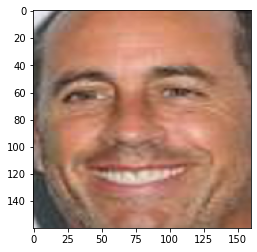

In [35]:
pred_my_example('jerry.jpg',model1,model2,norm,lab)